In [ ]:


!pip install datasets --quiet
!pip install --force-reinstall nltk --quiet

import json
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
from string import punctuation
from datasets import load_dataset
from tqdm import tqdm
# LOADING VOCAB.JSON
with open("vocab.json", "r") as f:
    vocab = json.load(f)
word2idx = vocab["word2idx"]




# Downloading  resources
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    doc = nlp(text)
    return [
        token.lemma_ for token in doc
        if token.is_alpha and token.text not in stop_words and token.text not in punctuation
    ]

with open("preprocessed_data.json", "r") as f:
    your_records = json.load(f)
df_own = pd.DataFrame(your_records)

# Mapping  word-sentiments → numeric (0=neg,1=neu,2=pos)
word2num = {"negative": 0, "neutral": 1, "positive": 2}
df_own["sentiment_num"] = df_own["Sentiment"].map(word2num)

print("Your data sample:")
print(df_own[["Sentence","Sentiment","sentiment_num","tokens"]].head(), "\n")

# ─── 2. Loading  TimKoornstra labeled dataset ────────────────────
hf = load_dataset("TimKoornstra/financial-tweets-sentiment", split="train")

print("\nDataset features:", hf.features)
print("\nFirst sample:", hf[0])

text_column = "tweet"
sentiment_column = "sentiment"

hf_label_map = {2: 0, 0: 1, 1: 2}

records = []
for item in tqdm(hf, desc="Processing TimKoornstra HF"):
    try:
        txt = item[text_column]
        lbl = item[sentiment_column]
        toks = preprocess_text(txt)
        if toks:
            records.append({
                "sentence": txt,
                "sentiment_num": hf_label_map[lbl],
                "tokens": toks
            })
    except KeyError as e:
        print(f"Skipping item due to missing key: {e}")
        continue

df_tim = pd.DataFrame(records)
print("\nTimKoornstra sample:")
print(df_tim.head(), "\n")
print(f"Loaded {len(df_tim)} records from TimKoornstra dataset")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Your data sample:
                                            Sentence Sentiment  sentiment_num  \
0  The GeoSolutions technology will leverage Bene...  positive              2   
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative              0   
2  For the last quarter of 2010 , Componenta 's n...  positive              2   
3  According to the Finnish-Russian Chamber of Co...   neutral              1   
4  The Swedish buyout firm has sold its remaining...   neutral              1   

                                              tokens  
0  [geosolution, technology, leverage, benefon, g...  
1                  [esi, low, bk, real, possibility]  
2  [last, quarter, componenta, net, sale, double,...  
3  [accord, finnishrussian, chamber, commerce, ma...  
4  [swedish, buyout, firm, sell, remain, percent,...   



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Dataset features: {'tweet': Value(dtype='string', id=None), 'sentiment': ClassLabel(names=['neutral', 'bullish', 'bearish'], id=None), 'url': Value(dtype='string', id=None)}

First sample: {'tweet': '$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT', 'sentiment': 2, 'url': 'https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment'}


Processing TimKoornstra HF: 100%|██████████| 38091/38091 [03:03<00:00, 207.35it/s]



TimKoornstra sample:
                                            sentence  sentiment_num  \
0  $BYND - JPMorgan reels in expectations on Beyo...              0   
1  $CCL $RCL - Nomura points to bookings weakness...              0   
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...              0   
3  $ESS: BTIG Research cuts to Neutral https://t....              0   
4  $FNKO - Funko slides after Piper Jaffray PT cu...              0   

                                              tokens  
0  [bynd, jpmorgan, reel, expectation, beyond, meat]  
1  [ccl, rcl, nomura, point, booking, weakness, c...  
2  [cx, cemex, cut, credit, suisse, jp, morgan, w...  
3                [ess, btig, research, cut, neutral]  
4      [fnko, funko, slide, piper, jaffray, pt, cut]   

Loaded 38079 records from TimKoornstra dataset


In [ ]:
from google.colab import files

# ─── Merging  the Two DataFrames ───────────────────────────────────
combined_df = pd.concat(
    [df_own[["tokens", "sentiment_num"]], df_tim[["tokens", "sentiment_num"]]],
    ignore_index=True
)

print(f"✅ Combined dataset size: {len(combined_df)} rows")
print(combined_df.head())
combined_df.to_json("combined_dataset.json", orient="records", indent=2)
combined_df.to_csv("combined_dataset.csv", index=False)


✅ Combined dataset size: 43921 rows
                                              tokens  sentiment_num
0  [geosolution, technology, leverage, benefon, g...              2
1                  [esi, low, bk, real, possibility]              0
2  [last, quarter, componenta, net, sale, double,...              2
3  [accord, finnishrussian, chamber, commerce, ma...              1
4  [swedish, buyout, firm, sell, remain, percent,...              1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-3-3f45f56b96a5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df, x="label_name", palette="pastel")


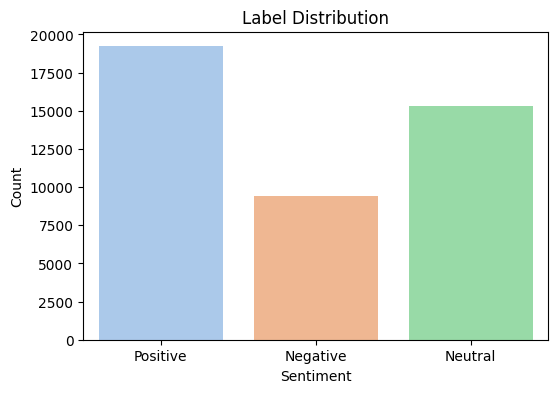

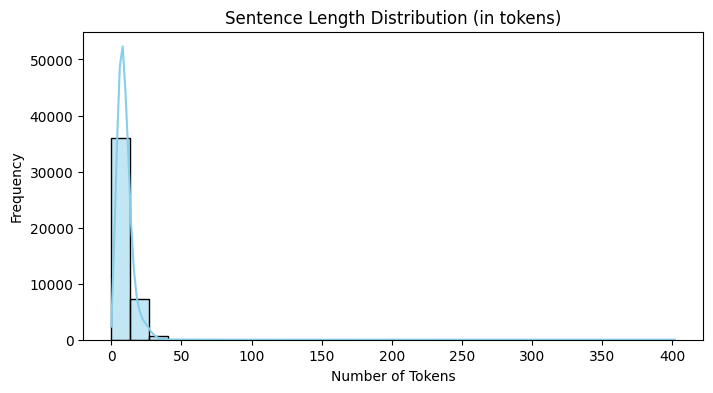

Sentence length stats:
Min: 0, Max: 402
Mean: 9.69, Median: 9.0


<ipython-input-3-3f45f56b96a5>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tokens), y=list(freqs), palette="mako")


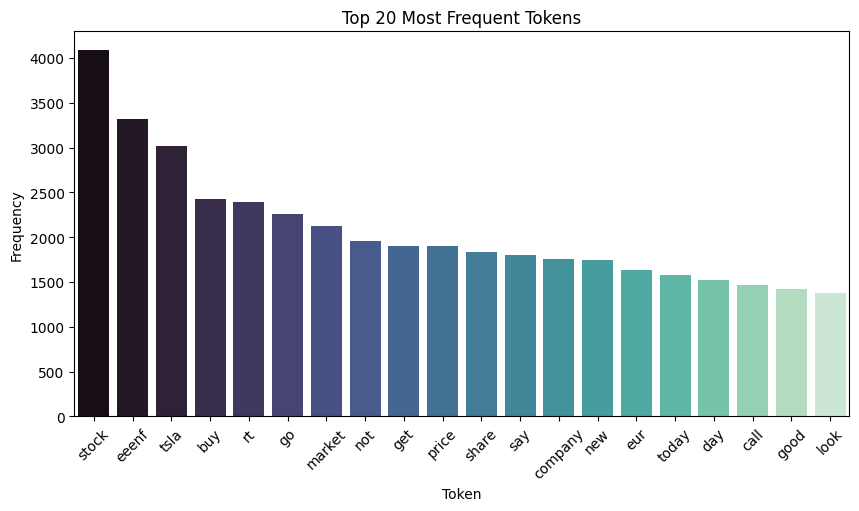

📚 Total unique tokens (vocabulary size): 35931


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

pd.set_option('display.max_colwidth', 120)

# ─── 1. Label distribution ──────────────────────────────────────
label_names = {0: "Negative", 1: "Neutral", 2: "Positive"}
combined_df["label_name"] = combined_df["sentiment_num"].map(label_names)

plt.figure(figsize=(6, 4))
sns.countplot(data=combined_df, x="label_name", palette="pastel")
plt.title("Label Distribution")
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.show()

# ─── 2. Sentence length distribution ────────────────────────────
sentence_lengths = combined_df["tokens"].apply(len)

plt.figure(figsize=(8, 4))
sns.histplot(sentence_lengths, bins=30, kde=True, color="skyblue")
plt.title("Sentence Length Distribution (in tokens)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

print(f"Sentence length stats:")
print(f"Min: {sentence_lengths.min()}, Max: {sentence_lengths.max()}")
print(f"Mean: {sentence_lengths.mean():.2f}, Median: {sentence_lengths.median()}")

# ─── 3. Most common tokens ──────────────────────────────────────
all_tokens = [t for tokens in combined_df["tokens"] for t in tokens]
token_counts = Counter(all_tokens)
common_words = token_counts.most_common(20)

tokens, freqs = zip(*common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(tokens), y=list(freqs), palette="mako")
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Tokens")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.show()

# ─── 4. Vocabulary Size ─────────────────────────────────────────
vocab_size = len(token_counts)
print(f"📚 Total unique tokens (vocabulary size): {vocab_size}")


In [ ]:
import json
from tqdm import tqdm

# ─── Generate skip-gram pairs ────────────────────────────────────
WINDOW_SIZE = 2
skipgram_pairs = []

for record in tqdm(data, desc="Generating skip-gram pairs"):
    tokens = record["tokens"]
    token_ids = [word2idx[t] for t in tokens if t in word2idx]
    for i, center_id in enumerate(token_ids):
        for offset in range(-WINDOW_SIZE, WINDOW_SIZE + 1):
            context_pos = i + offset
            if offset == 0 or context_pos < 0 or context_pos >= len(token_ids):
                continue
            context_id = token_ids[context_pos]
            skipgram_pairs.append((center_id, context_id))

print(f"✅ Generated {len(skipgram_pairs):,} skip-gram pairs")


Generating skip-gram pairs: 100%|██████████| 43921/43921 [00:01<00:00, 32313.31it/s]

✅ Generated 1,314,326 skip-gram pairs


In [ ]:
import numpy as np
import random


# ─── Hyperparameters ──────────────────────────────────────────────
vocab_size = len(word2idx)
embedding_dim = 100
learning_rate = 0.005
epochs = 10
neg_samples = 2

# ─── Weight Initialization ───────────────────────────────────────
W1 = np.random.randn(vocab_size, embedding_dim) * 0.01  # input embeddings
W2 = np.random.randn(vocab_size, embedding_dim) * 0.01  # output embeddings

# ─── Utility Functions ───────────────────────────────────────────
def sigmoid(x):
    x = np.clip(x, -10, 10)  # 🔧 prevent overflow
    return 1.0 / (1.0 + np.exp(-x))

def get_negative_samples(true_id, k):
    samples = []
    while len(samples) < k:
        neg = random.randint(0, vocab_size - 1)
        if neg != true_id:
            samples.append(neg)
    return samples

def clip_norms(W, max_norm=5.0):
    norms = np.linalg.norm(W, axis=1, keepdims=True)
    scale = np.clip(norms, 0, max_norm) / (norms + 1e-8)
    return W * scale

# ─── Training Loop ───────────────────────────────────────────────
for epoch in range(epochs):
    total_loss = 0.0
    np.random.shuffle(skipgram_pairs)

    print(f"\n🟢 Epoch {epoch+1}/{epochs}")
    for i, (target_id, context_id) in enumerate(tqdm(skipgram_pairs, desc="Training", unit="pair")):
        v_t = W1[target_id]
        u_c = W2[context_id]

        # Positive sample
        score_pos = sigmoid(np.dot(u_c, v_t))
        loss_pos = -np.log(score_pos + 1e-8)
        total_loss += loss_pos

        grad_pos = score_pos - 1
        W2[context_id] -= learning_rate * grad_pos * v_t
        grad_v = grad_pos * u_c

        # Negative samples
        for neg_id in get_negative_samples(context_id, neg_samples):
            u_k = W2[neg_id]
            score_neg = sigmoid(-np.dot(u_k, v_t))
            loss_neg = -np.log(score_neg + 1e-8)
            total_loss += loss_neg

            grad_neg = (1 - score_neg)
            W2[neg_id] -= learning_rate * grad_neg * v_t
            grad_v += grad_neg * u_k

        # Update input embedding
        W1[target_id] -= learning_rate * grad_v

        # Optional: print loss every 100k
        if (i + 1) % 100000 == 0:
            tqdm.write(f"Pair {i+1}/{len(skipgram_pairs)} — Avg Loss: {total_loss / (i+1):.4f}")

    # Clip norms to prevent divergence
    W1 = clip_norms(W1)
    W2 = clip_norms(W2)

    print(f"✅ Epoch {epoch+1} complete. Total Loss: {total_loss:.2f}")



🟢 Epoch 1/10


Training:   8%|▊         | 103002/1314326 [00:08<01:29, 13585.09pair/s]

Pair 100000/1314326 — Avg Loss: 2.0794


Training:  15%|█▌        | 201558/1314326 [00:16<01:12, 15301.39pair/s]

Pair 200000/1314326 — Avg Loss: 2.0794


Training:  23%|██▎       | 301616/1314326 [00:23<01:08, 14756.41pair/s]

Pair 300000/1314326 — Avg Loss: 2.0794


Training:  31%|███       | 402747/1314326 [00:32<01:01, 14888.67pair/s]

Pair 400000/1314326 — Avg Loss: 2.0794


Training:  38%|███▊      | 501697/1314326 [00:40<01:00, 13367.07pair/s]

Pair 500000/1314326 — Avg Loss: 2.0793


Training:  46%|████▌     | 601838/1314326 [00:48<00:49, 14290.18pair/s]

Pair 600000/1314326 — Avg Loss: 2.0793


Training:  53%|█████▎    | 702448/1314326 [00:56<00:47, 12928.60pair/s]

Pair 700000/1314326 — Avg Loss: 2.0792


Training:  61%|██████    | 801844/1314326 [01:04<00:55, 9248.60pair/s]

Pair 800000/1314326 — Avg Loss: 2.0791


Training:  69%|██████▊   | 902538/1314326 [01:12<00:29, 13851.13pair/s]

Pair 900000/1314326 — Avg Loss: 2.0788


Training:  76%|███████▌  | 1002104/1314326 [01:19<00:18, 16553.63pair/s]

Pair 1000000/1314326 — Avg Loss: 2.0784


Training:  84%|████████▍ | 1102363/1314326 [01:25<00:12, 16371.94pair/s]

Pair 1100000/1314326 — Avg Loss: 2.0779


Training:  92%|█████████▏| 1203450/1314326 [01:32<00:07, 14486.55pair/s]

Pair 1200000/1314326 — Avg Loss: 2.0770


Training:  99%|█████████▉| 1302368/1314326 [01:39<00:00, 13740.72pair/s]

Pair 1300000/1314326 — Avg Loss: 2.0756


Training: 100%|██████████| 1314326/1314326 [01:40<00:00, 13130.48pair/s]


✅ Epoch 1 complete. Total Loss: 2727760.47

🟢 Epoch 2/10


Training:   8%|▊         | 101875/1314326 [00:07<01:31, 13239.03pair/s]

Pair 100000/1314326 — Avg Loss: 2.0470


Training:  15%|█▌        | 201165/1314326 [00:14<01:36, 11499.75pair/s]

Pair 200000/1314326 — Avg Loss: 2.0392


Training:  23%|██▎       | 301655/1314326 [00:21<01:02, 16215.49pair/s]

Pair 300000/1314326 — Avg Loss: 2.0309


Training:  31%|███       | 401563/1314326 [00:28<01:21, 11179.33pair/s]

Pair 400000/1314326 — Avg Loss: 2.0217


Training:  38%|███▊      | 504048/1314326 [00:35<00:49, 16435.94pair/s]

Pair 500000/1314326 — Avg Loss: 2.0118


Training:  46%|████▌     | 602476/1314326 [00:43<00:56, 12504.87pair/s]

Pair 600000/1314326 — Avg Loss: 2.0016


Training:  53%|█████▎    | 701497/1314326 [00:49<00:45, 13583.22pair/s]

Pair 700000/1314326 — Avg Loss: 1.9912


Training:  61%|██████    | 803123/1314326 [00:56<00:32, 15604.45pair/s]

Pair 800000/1314326 — Avg Loss: 1.9805


Training:  69%|██████▉   | 903611/1314326 [01:03<00:24, 16972.52pair/s]

Pair 900000/1314326 — Avg Loss: 1.9698


Training:  76%|███████▋  | 1002560/1314326 [01:10<00:19, 15707.54pair/s]

Pair 1000000/1314326 — Avg Loss: 1.9591


Training:  84%|████████▍ | 1101794/1314326 [01:16<00:12, 17128.36pair/s]

Pair 1100000/1314326 — Avg Loss: 1.9481


Training:  91%|█████████▏| 1201569/1314326 [01:23<00:07, 14616.98pair/s]

Pair 1200000/1314326 — Avg Loss: 1.9371


Training:  99%|█████████▉| 1303418/1314326 [01:30<00:00, 17280.41pair/s]

Pair 1300000/1314326 — Avg Loss: 1.9263


Training: 100%|██████████| 1314326/1314326 [01:31<00:00, 14391.34pair/s]


✅ Epoch 2 complete. Total Loss: 2529582.51

🟢 Epoch 3/10


Training:   8%|▊         | 101653/1314326 [00:06<01:25, 14191.85pair/s]

Pair 100000/1314326 — Avg Loss: 1.7689


Training:  15%|█▌        | 202140/1314326 [00:14<01:21, 13718.60pair/s]

Pair 200000/1314326 — Avg Loss: 1.7589


Training:  23%|██▎       | 302250/1314326 [00:20<01:11, 14069.03pair/s]

Pair 300000/1314326 — Avg Loss: 1.7478


Training:  31%|███       | 403237/1314326 [00:28<01:02, 14479.58pair/s]

Pair 400000/1314326 — Avg Loss: 1.7362


Training:  38%|███▊      | 501666/1314326 [00:34<00:51, 15904.68pair/s]

Pair 500000/1314326 — Avg Loss: 1.7245


Training:  46%|████▌     | 602403/1314326 [00:42<00:45, 15516.12pair/s]

Pair 600000/1314326 — Avg Loss: 1.7132


Training:  53%|█████▎    | 702273/1314326 [00:48<00:48, 12510.76pair/s]

Pair 700000/1314326 — Avg Loss: 1.7019


Training:  61%|██████    | 802843/1314326 [00:56<00:33, 15346.87pair/s]

Pair 800000/1314326 — Avg Loss: 1.6908


Training:  69%|██████▊   | 902010/1314326 [01:02<00:28, 14491.37pair/s]

Pair 900000/1314326 — Avg Loss: 1.6797


Training:  76%|███████▌  | 1001661/1314326 [01:09<00:21, 14695.49pair/s]

Pair 1000000/1314326 — Avg Loss: 1.6686


Training:  84%|████████▍ | 1101274/1314326 [01:16<00:18, 11717.46pair/s]

Pair 1100000/1314326 — Avg Loss: 1.6574


Training:  91%|█████████▏| 1202527/1314326 [01:23<00:06, 16820.52pair/s]

Pair 1200000/1314326 — Avg Loss: 1.6464


Training:  99%|█████████▉| 1301696/1314326 [01:30<00:01, 11530.66pair/s]

Pair 1300000/1314326 — Avg Loss: 1.6354


Training: 100%|██████████| 1314326/1314326 [01:31<00:00, 14412.51pair/s]


✅ Epoch 3 complete. Total Loss: 2147395.47

🟢 Epoch 4/10


Training:   8%|▊         | 102681/1314326 [00:07<01:24, 14384.05pair/s]

Pair 100000/1314326 — Avg Loss: 1.4805


Training:  15%|█▌        | 202734/1314326 [00:14<01:11, 15449.80pair/s]

Pair 200000/1314326 — Avg Loss: 1.4687


Training:  23%|██▎       | 302447/1314326 [00:21<01:07, 15005.54pair/s]

Pair 300000/1314326 — Avg Loss: 1.4578


Training:  31%|███       | 402768/1314326 [00:28<00:49, 18420.35pair/s]

Pair 400000/1314326 — Avg Loss: 1.4465


Training:  38%|███▊      | 503292/1314326 [00:34<00:54, 14824.00pair/s]

Pair 500000/1314326 — Avg Loss: 1.4370


Training:  46%|████▌     | 601908/1314326 [00:41<00:51, 13747.21pair/s]

Pair 600000/1314326 — Avg Loss: 1.4273


Training:  53%|█████▎    | 700851/1314326 [00:48<00:46, 13186.51pair/s]

Pair 700000/1314326 — Avg Loss: 1.4174


Training:  61%|██████    | 802942/1314326 [00:55<00:27, 18268.86pair/s]

Pair 800000/1314326 — Avg Loss: 1.4080


Training:  69%|██████▊   | 902152/1314326 [01:02<00:35, 11566.52pair/s]

Pair 900000/1314326 — Avg Loss: 1.3989


Training:  76%|███████▋  | 1002714/1314326 [01:09<00:19, 15727.85pair/s]

Pair 1000000/1314326 — Avg Loss: 1.3902


Training:  84%|████████▍ | 1102101/1314326 [01:16<00:19, 10931.83pair/s]

Pair 1100000/1314326 — Avg Loss: 1.3818


Training:  91%|█████████▏| 1201134/1314326 [01:23<00:09, 11533.62pair/s]

Pair 1200000/1314326 — Avg Loss: 1.3731


Training:  99%|█████████▉| 1303656/1314326 [01:32<00:00, 15251.63pair/s]

Pair 1300000/1314326 — Avg Loss: 1.3642


Training: 100%|██████████| 1314326/1314326 [01:32<00:00, 14160.78pair/s]


✅ Epoch 4 complete. Total Loss: 1791435.82

🟢 Epoch 5/10


Training:   8%|▊         | 101287/1314326 [00:06<01:35, 12751.72pair/s]

Pair 100000/1314326 — Avg Loss: 1.2468


Training:  15%|█▌        | 203664/1314326 [00:13<01:07, 16462.41pair/s]

Pair 200000/1314326 — Avg Loss: 1.2386


Training:  23%|██▎       | 301471/1314326 [00:20<01:30, 11170.05pair/s]

Pair 300000/1314326 — Avg Loss: 1.2312


Training:  31%|███       | 402998/1314326 [00:27<00:56, 16013.93pair/s]

Pair 400000/1314326 — Avg Loss: 1.2249


Training:  38%|███▊      | 502858/1314326 [00:35<00:54, 15004.74pair/s]

Pair 500000/1314326 — Avg Loss: 1.2182


Training:  46%|████▌     | 602558/1314326 [00:41<00:49, 14314.93pair/s]

Pair 600000/1314326 — Avg Loss: 1.2119


Training:  54%|█████▎    | 703616/1314326 [00:48<00:35, 17262.53pair/s]

Pair 700000/1314326 — Avg Loss: 1.2058


Training:  61%|██████    | 802701/1314326 [00:55<00:35, 14422.85pair/s]

Pair 800000/1314326 — Avg Loss: 1.1998


Training:  69%|██████▊   | 902091/1314326 [01:02<00:24, 16654.08pair/s]

Pair 900000/1314326 — Avg Loss: 1.1939


Training:  76%|███████▌  | 1001643/1314326 [01:09<00:22, 14196.93pair/s]

Pair 1000000/1314326 — Avg Loss: 1.1880


Training:  84%|████████▍ | 1102212/1314326 [01:16<00:15, 14023.85pair/s]

Pair 1100000/1314326 — Avg Loss: 1.1826


Training:  91%|█████████▏| 1201911/1314326 [01:22<00:07, 14689.96pair/s]

Pair 1200000/1314326 — Avg Loss: 1.1774


Training:  99%|█████████▉| 1302109/1314326 [01:29<00:00, 15888.85pair/s]

Pair 1300000/1314326 — Avg Loss: 1.1725


Training: 100%|██████████| 1314326/1314326 [01:30<00:00, 14498.79pair/s]


✅ Epoch 5 complete. Total Loss: 1540024.71

🟢 Epoch 6/10


Training:   8%|▊         | 102109/1314326 [00:06<01:46, 11382.30pair/s]

Pair 100000/1314326 — Avg Loss: 1.0952


Training:  15%|█▌        | 202193/1314326 [00:13<01:15, 14758.18pair/s]

Pair 200000/1314326 — Avg Loss: 1.0901


Training:  23%|██▎       | 302088/1314326 [00:20<01:34, 10754.82pair/s]

Pair 300000/1314326 — Avg Loss: 1.0863


Training:  31%|███       | 402394/1314326 [00:26<00:55, 16512.66pair/s]

Pair 400000/1314326 — Avg Loss: 1.0823


Training:  38%|███▊      | 503370/1314326 [00:34<00:55, 14561.22pair/s]

Pair 500000/1314326 — Avg Loss: 1.0774


Training:  46%|████▌     | 602661/1314326 [00:40<00:47, 14985.14pair/s]

Pair 600000/1314326 — Avg Loss: 1.0733


Training:  54%|█████▎    | 703415/1314326 [00:47<00:37, 16422.28pair/s]

Pair 700000/1314326 — Avg Loss: 1.0699


Training:  61%|██████    | 803062/1314326 [00:54<00:30, 16731.34pair/s]

Pair 800000/1314326 — Avg Loss: 1.0662


Training:  69%|██████▊   | 901611/1314326 [01:01<00:30, 13411.24pair/s]

Pair 900000/1314326 — Avg Loss: 1.0627


Training:  76%|███████▋  | 1003072/1314326 [01:08<00:18, 16772.47pair/s]

Pair 1000000/1314326 — Avg Loss: 1.0590


Training:  84%|████████▍ | 1102783/1314326 [01:15<00:14, 15037.73pair/s]

Pair 1100000/1314326 — Avg Loss: 1.0556


Training:  92%|█████████▏| 1202743/1314326 [01:21<00:06, 16483.04pair/s]

Pair 1200000/1314326 — Avg Loss: 1.0516


Training:  99%|█████████▉| 1302482/1314326 [01:29<00:00, 14070.97pair/s]

Pair 1300000/1314326 — Avg Loss: 1.0482


Training: 100%|██████████| 1314326/1314326 [01:30<00:00, 14579.29pair/s]


✅ Epoch 6 complete. Total Loss: 1377015.40

🟢 Epoch 7/10


Training:   8%|▊         | 101540/1314326 [00:07<01:45, 11518.50pair/s]

Pair 100000/1314326 — Avg Loss: 0.9977


Training:  15%|█▌        | 203153/1314326 [00:14<01:15, 14784.88pair/s]

Pair 200000/1314326 — Avg Loss: 0.9932


Training:  23%|██▎       | 302103/1314326 [00:21<01:11, 14180.71pair/s]

Pair 300000/1314326 — Avg Loss: 0.9906


Training:  31%|███       | 402043/1314326 [00:28<01:02, 14525.20pair/s]

Pair 400000/1314326 — Avg Loss: 0.9879


Training:  38%|███▊      | 503883/1314326 [00:35<00:51, 15875.83pair/s]

Pair 500000/1314326 — Avg Loss: 0.9856


Training:  46%|████▌     | 603505/1314326 [00:41<00:43, 16275.22pair/s]

Pair 600000/1314326 — Avg Loss: 0.9826


Training:  53%|█████▎    | 701749/1314326 [00:49<00:37, 16327.16pair/s]

Pair 700000/1314326 — Avg Loss: 0.9799


Training:  61%|██████    | 802551/1314326 [00:55<00:33, 15206.97pair/s]

Pair 800000/1314326 — Avg Loss: 0.9765


Training:  69%|██████▊   | 902630/1314326 [01:02<00:29, 14160.87pair/s]

Pair 900000/1314326 — Avg Loss: 0.9743


Training:  76%|███████▌  | 1001446/1314326 [01:09<00:23, 13568.81pair/s]

Pair 1000000/1314326 — Avg Loss: 0.9716


Training:  84%|████████▍ | 1101871/1314326 [01:16<00:14, 14326.68pair/s]

Pair 1100000/1314326 — Avg Loss: 0.9691


Training:  91%|█████████▏| 1202245/1314326 [01:23<00:10, 11022.41pair/s]

Pair 1200000/1314326 — Avg Loss: 0.9669


Training:  99%|█████████▉| 1302496/1314326 [01:30<00:00, 13886.74pair/s]

Pair 1300000/1314326 — Avg Loss: 0.9645


Training: 100%|██████████| 1314326/1314326 [01:31<00:00, 14370.85pair/s]


✅ Epoch 7 complete. Total Loss: 1267246.02

🟢 Epoch 8/10


Training:   8%|▊         | 102958/1314326 [00:07<01:15, 15995.18pair/s]

Pair 100000/1314326 — Avg Loss: 0.9269


Training:  15%|█▌        | 203040/1314326 [00:13<01:09, 16061.28pair/s]

Pair 200000/1314326 — Avg Loss: 0.9273


Training:  23%|██▎       | 301505/1314326 [00:21<00:58, 17204.52pair/s]

Pair 300000/1314326 — Avg Loss: 0.9257


Training:  31%|███       | 402838/1314326 [00:27<00:55, 16475.93pair/s]

Pair 400000/1314326 — Avg Loss: 0.9223


Training:  38%|███▊      | 502048/1314326 [00:34<01:01, 13118.03pair/s]

Pair 500000/1314326 — Avg Loss: 0.9210


Training:  46%|████▌     | 601358/1314326 [00:41<00:49, 14420.30pair/s]

Pair 600000/1314326 — Avg Loss: 0.9188


Training:  53%|█████▎    | 702034/1314326 [00:48<00:37, 16289.95pair/s]

Pair 700000/1314326 — Avg Loss: 0.9175


Training:  61%|██████    | 802116/1314326 [00:56<00:46, 11113.50pair/s]

Pair 800000/1314326 — Avg Loss: 0.9160


Training:  69%|██████▊   | 902668/1314326 [01:02<00:28, 14567.20pair/s]

Pair 900000/1314326 — Avg Loss: 0.9141


Training:  76%|███████▌  | 1001698/1314326 [01:09<00:27, 11245.61pair/s]

Pair 1000000/1314326 — Avg Loss: 0.9122


Training:  84%|████████▍ | 1101716/1314326 [01:16<00:11, 17731.40pair/s]

Pair 1100000/1314326 — Avg Loss: 0.9107


Training:  91%|█████████▏| 1201558/1314326 [01:23<00:07, 15515.53pair/s]

Pair 1200000/1314326 — Avg Loss: 0.9089


Training:  99%|█████████▉| 1301940/1314326 [01:30<00:00, 18405.77pair/s]

Pair 1300000/1314326 — Avg Loss: 0.9074


Training: 100%|██████████| 1314326/1314326 [01:31<00:00, 14403.53pair/s]


✅ Epoch 8 complete. Total Loss: 1192273.95

🟢 Epoch 9/10


Training:   8%|▊         | 102968/1314326 [00:07<01:20, 15086.88pair/s]

Pair 100000/1314326 — Avg Loss: 0.8789


Training:  15%|█▌        | 202298/1314326 [00:13<01:11, 15661.78pair/s]

Pair 200000/1314326 — Avg Loss: 0.8778


Training:  23%|██▎       | 302409/1314326 [00:21<01:11, 14229.90pair/s]

Pair 300000/1314326 — Avg Loss: 0.8776


Training:  31%|███       | 401323/1314326 [00:27<01:19, 11454.09pair/s]

Pair 400000/1314326 — Avg Loss: 0.8766


Training:  38%|███▊      | 501721/1314326 [00:34<00:59, 13699.35pair/s]

Pair 500000/1314326 — Avg Loss: 0.8748


Training:  46%|████▌     | 601505/1314326 [00:41<01:03, 11284.61pair/s]

Pair 600000/1314326 — Avg Loss: 0.8732


Training:  53%|█████▎    | 702503/1314326 [00:48<00:44, 13882.43pair/s]

Pair 700000/1314326 — Avg Loss: 0.8726


Training:  61%|██████    | 801327/1314326 [00:55<00:47, 10867.52pair/s]

Pair 800000/1314326 — Avg Loss: 0.8720


Training:  69%|██████▊   | 901846/1314326 [01:02<00:25, 15962.85pair/s]

Pair 900000/1314326 — Avg Loss: 0.8712


Training:  76%|███████▋  | 1003678/1314326 [01:09<00:17, 17902.90pair/s]

Pair 1000000/1314326 — Avg Loss: 0.8701


Training:  84%|████████▍ | 1103217/1314326 [01:16<00:13, 15386.55pair/s]

Pair 1100000/1314326 — Avg Loss: 0.8697


Training:  92%|█████████▏| 1202853/1314326 [01:23<00:08, 13537.11pair/s]

Pair 1200000/1314326 — Avg Loss: 0.8683


Training:  99%|█████████▉| 1302520/1314326 [01:29<00:00, 16266.66pair/s]

Pair 1300000/1314326 — Avg Loss: 0.8668


Training: 100%|██████████| 1314326/1314326 [01:30<00:00, 14544.97pair/s]


✅ Epoch 9 complete. Total Loss: 1139178.68

🟢 Epoch 10/10


Training:   8%|▊         | 101755/1314326 [00:07<01:23, 14572.96pair/s]

Pair 100000/1314326 — Avg Loss: 0.8395


Training:  15%|█▌        | 201641/1314326 [00:14<01:22, 13430.28pair/s]

Pair 200000/1314326 — Avg Loss: 0.8407


Training:  23%|██▎       | 302586/1314326 [00:21<01:04, 15652.62pair/s]

Pair 300000/1314326 — Avg Loss: 0.8432


Training:  31%|███       | 401372/1314326 [00:28<01:21, 11142.91pair/s]

Pair 400000/1314326 — Avg Loss: 0.8421


Training:  38%|███▊      | 502387/1314326 [00:35<00:51, 15847.30pair/s]

Pair 500000/1314326 — Avg Loss: 0.8416


Training:  46%|████▌     | 601951/1314326 [00:42<01:07, 10619.20pair/s]

Pair 600000/1314326 — Avg Loss: 0.8416


Training:  53%|█████▎    | 702622/1314326 [00:48<00:38, 15950.96pair/s]

Pair 700000/1314326 — Avg Loss: 0.8400


Training:  61%|██████    | 802501/1314326 [00:56<00:37, 13796.97pair/s]

Pair 800000/1314326 — Avg Loss: 0.8390


Training:  69%|██████▊   | 902399/1314326 [01:02<00:25, 16052.91pair/s]

Pair 900000/1314326 — Avg Loss: 0.8378


Training:  76%|███████▌  | 1001711/1314326 [01:10<00:18, 16653.84pair/s]

Pair 1000000/1314326 — Avg Loss: 0.8366


Training:  84%|████████▍ | 1101288/1314326 [01:16<00:13, 15529.94pair/s]

Pair 1100000/1314326 — Avg Loss: 0.8358


Training:  91%|█████████▏| 1202333/1314326 [01:24<00:07, 15198.08pair/s]

Pair 1200000/1314326 — Avg Loss: 0.8353


Training:  99%|█████████▉| 1302755/1314326 [01:30<00:00, 16224.29pair/s]

Pair 1300000/1314326 — Avg Loss: 0.8344


Training: 100%|██████████| 1314326/1314326 [01:31<00:00, 14425.88pair/s]


✅ Epoch 10 complete. Total Loss: 1096480.55


In [ ]:

np.save("embeddings.npy", W1)
print("✅ Embeddings saved to embeddings.npy")

from google.colab import files
files.download("embeddings.npy")


✅ Embeddings saved to embeddings.npy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
embeddings = np.load("embeddings.npy")

In [ ]:
print("Shape of embeddings:", embeddings.shape)

Shape of embeddings: (52192, 100)


In [ ]:
print("\nFirst row of embeddings:", embeddings[0])


First row of embeddings: [ 0.01804558  0.20097414  0.04445281  0.04280125 -0.06043518 -0.07726021
  0.22436474 -0.11053206  0.08258887  0.00703982 -0.13858681 -0.21069416
  0.02999031 -0.01360768 -0.19378256  0.02769704  0.14498973  0.09382641
 -0.01797931  0.24050915  0.01582521  0.10809689 -0.21972244  0.27056629
  0.06599673 -0.04210092 -0.29806174  0.16285899  0.2572556  -0.2986685
  0.04380296 -0.09179995 -0.11963508 -0.04257883  0.06745546  0.13880553
 -0.13530226 -0.00123953 -0.01586354 -0.16510882  0.0546694  -0.06764663
  0.02564681  0.10867562  0.03139395  0.01046717  0.02368016  0.05200477
 -0.13576592  0.01369606  0.17395707 -0.12280355  0.13158432 -0.018689
 -0.14860027 -0.19395836  0.01300044 -0.09425833 -0.13857473 -0.09091381
 -0.01209207 -0.03246356  0.1159127   0.18520133 -0.12541694 -0.08226508
 -0.11430298 -0.142937    0.06775002  0.23687952  0.17120716  0.32039282
  0.08877082 -0.17569515  0.07620437  0.23536509 -0.05222696 -0.18306479
 -0.05381058  0.15459679  0.